# NBA Hall of Fame Prediction
This project aims to predict whether an NBA player will be inducted into the Hall of Fame based on their career statistics. Using a dataset of over 5,000 players, we build a machine learning model to classify players as Hall of Famers or not, leveraging key performance metrics and player attributes.

# Load NBA Dataset
The dataset contains 5,313 NBA players with 20 features including player stats (points, rebounds, assists), biographical info (height, weight), and career details (debut year, final year). The target variable HOF indicates Hall of Fame induction and is highly imbalanced, with only about 3.3% inducted.

In [38]:
import pandas as pd
df = pd.read_csv("NBA_PLAYERS.csv")
df.head()
df.info()
df['HOF'].value_counts(normalize=True)  # Check class imbalance


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5313 entries, 0 to 5312
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5313 non-null   object 
 1   Debut     5313 non-null   int64  
 2   Final     5313 non-null   int64  
 3   Position  5313 non-null   object 
 4   Height    5313 non-null   int64  
 5   Weight    5308 non-null   float64
 6   Birthday  5297 non-null   object 
 7   School    4917 non-null   object 
 8   HOF       5313 non-null   bool   
 9   Active    5313 non-null   bool   
 10  G         5313 non-null   int64  
 11  PTS       5313 non-null   float64
 12  TRB       5021 non-null   float64
 13  AST       5313 non-null   float64
 14  FG%       5278 non-null   float64
 15  FG3%      3656 non-null   float64
 16  FT%       5060 non-null   float64
 17  eFG%      4156 non-null   float64
 18  PER       4965 non-null   float64
 19  WS        5312 non-null   float64
dtypes: bool(2), float64(10), int64

False    0.966685
True     0.033315
Name: HOF, dtype: float64

# Data Cleaning
We dropped non-numeric columns unlikely to aid prediction (e.g., Name, Debut year). Missing values were replaced with zeros for simplicity. Player positions were one-hot encoded to convert categorical data into numerical form suitable for modeling.

Features (X) include numeric stats and position indicators. The target (y) is a binary label representing Hall of Fame induction.

In [32]:
# Drop irrelevant or duplicate columns
df.drop(columns=["Name", "Debut", "Final", "Birthday", "School", "Active"], inplace=True)

# Clean Position (explode list if needed)
df = df.explode("Position")
df = pd.get_dummies(df, columns=["Position"], drop_first=True)

# Convert Height, Weight to numeric
df["Height"] = pd.to_numeric(df["Height"], errors='coerce')
df["Weight"] = pd.to_numeric(df["Weight"], errors='coerce')

# Fill NaNs (or impute)
df.fillna(0, inplace=True)

X = df.drop(columns=["HOF"])
y = df["HOF"].astype(int)

# Create Training and Test Data

The dataset was split into equal halves for training and testing (50/50 split) to evaluate model performance on unseen data, with a fixed random seed for reproducibility

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Create Regression Model
I used a Random Forest Classifier with 100 trees, a method suitable for tabular data, which can handle nonlinear relationships and feature interactions.

In [39]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluate the Model
The model achieves 98% accuracy, with a high precision (93%) but moderate recall (45%) on Hall of Fame players due to class imbalance. The ROC AUC of 0.95 indicates strong overall classification ability.

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2561
           1       0.93      0.45      0.61        96

    accuracy                           0.98      2657
   macro avg       0.96      0.72      0.80      2657
weighted avg       0.98      0.98      0.98      2657

ROC AUC: 0.9532795620200443


# Visualization
The feature importance plot shows which stats contribute most to predictions, highlighting the significance of win shares, points, games played, and player efficiency rating.

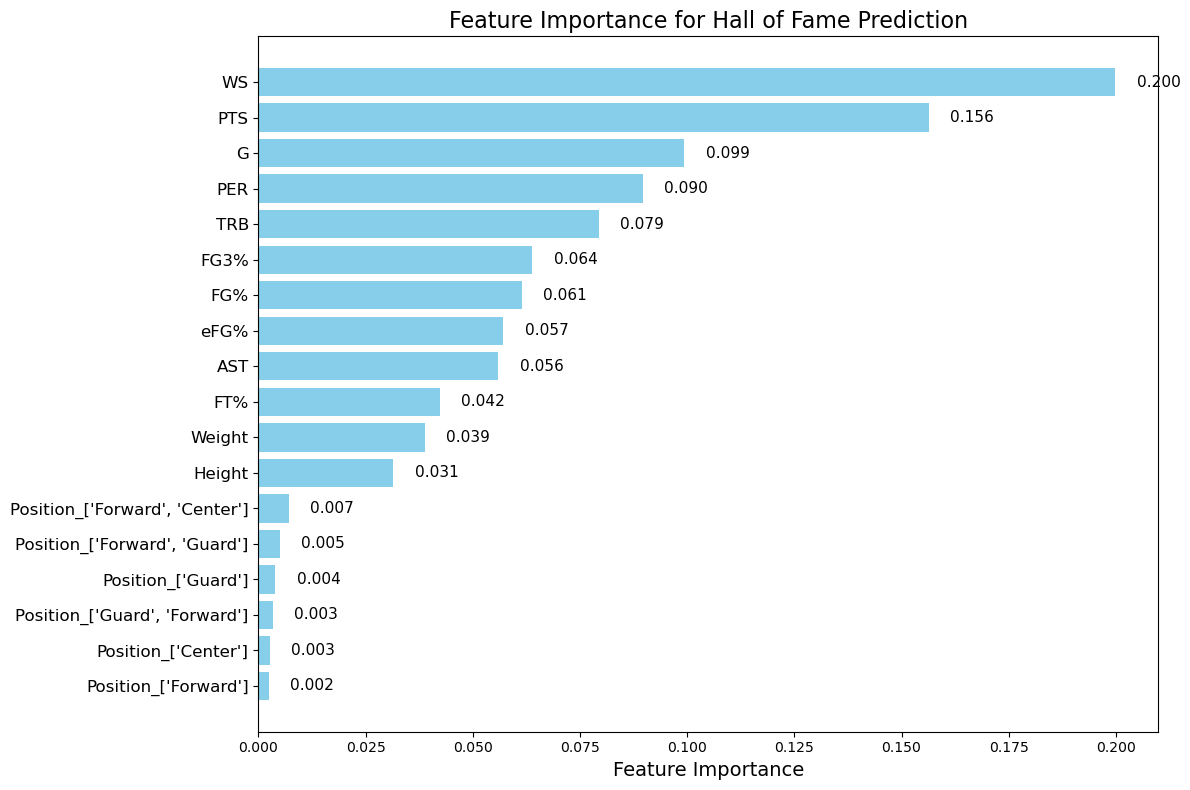

In [41]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
features = X.columns

# Sort features by importance descending
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(indices)), importances[indices], color='skyblue')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=12)
plt.xlabel('Feature Importance', fontsize=14)
plt.title('Feature Importance for Hall of Fame Prediction', fontsize=16)
plt.gca().invert_yaxis()  # Highest importance at the top

# Add data labels to bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=11)

plt.tight_layout()
plt.show()